In [1]:
import os
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import IPython.display as IPdisplay
from scipy.integrate import odeint
from mpl_toolkits.mplot3d.axes3d import Axes3D
from PIL import Image


In [2]:
# Random seed 
torch.manual_seed(10001)

# Read the data and convert it into tensor
train = pd.read_csv('N:/Complex_system/data/lorenz/xyz.csv')
train_tensor = torch.tensor(train.values)


### Scale the input: Haven't plotted the result; Model shows no learning for scaled input tensors

In [3]:
# from sklearn.preprocessing import MinMaxScaler

# x_scaler = MinMaxScaler()

# x_train_scaled = x_scaler.fit_transform(train_tensor[:99000])

In [4]:
# print(x_train_scaled,x_train_scaled.shape)

### Load Data

In [5]:
# Batch size
bs = 1024

# train_data_loader = torch.utils.data.DataLoader(x_train_scaled, batch_size=bs, shuffle=False)
train_data_loader = torch.utils.data.DataLoader(train_tensor, batch_size=bs,drop_last=True, shuffle=False)

# NOTE: Shuffle is set to false to preserve the sequence in data

#### Prechecks on data loader

In [6]:
batch = list(train_data_loader)[0]  # [bs,inp_dim]
print(batch.shape)


torch.Size([1024, 3])


### VAE model

##### Auto-Encoding Variational Bayes; Diederik P Kingma, Max Welling: https://arxiv.org/pdf/1312.6114.pdf

In [22]:
class VAE(nn.Module):
    def __init__(self, in_dim = 3, hidden_dim = 512, n_layers = 3, out_dim =3 ,z_dim= 20):
        
        super(VAE, self).__init__()
        
        # MODEL HYPERPARAMETERS
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim
        
        # ACTIVATION FUNCTIONS
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        # ENCODER
        self.encoder_lstm = nn.LSTM(in_dim, hidden_dim, n_layers, batch_first=True)                                  
        self.encoder_output = nn.Linear(hidden_dim, z_dim*2)
#         self.encoder_output = nn.Linear(hidden_dim, hidden_dim)
        
        # DECODER
        self.decoder_lstm = nn.LSTM(z_dim, hidden_dim, n_layers, batch_first=True) 
#         self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True)
        self.decoder_output = nn.Linear(hidden_dim, out_dim)
        
     
    # LATENT SAMPLER
    def reparameterize(self, mu, logvar):
        
        std = logvar.mul(0.5).exp_()
        esp = Variable(torch.randn(*mu.size())).cuda()
        z = mu + std * esp
        return z
                                          
    def forward(self, x):
        
        # Encoder
        enc_hidden = self._init_hidden()   
        enc,_ = self.encoder_lstm(x,enc_hidden)
        enc = self.relu(enc)

        # Reparameterize
        z_var = self.encoder_output(enc)
        mu,logvar = torch.chunk(z_var, 2, dim=2)     
        z = self.reparameterize(mu, logvar)
        
        # Decoder
        dec_hidden = self._init_hidden()
        dec,_ = self.decoder_lstm(z,dec_hidden)
#         dec,_ = self.decoder_lstm(enc,dec_hidden)
#         dec = self.relu(dec)
        dec = self.decoder_output(dec)
        
        return dec, mu, logvar
    
    
    def _init_hidden(self):
        return (torch.zeros(self.n_layers, bs, self.hidden_dim).cuda(), torch.zeros(self.n_layers, bs, self.hidden_dim).cuda())
        

In [23]:
vae = VAE()
if torch.cuda.is_available():
    vae.cuda()
vae

VAE(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (encoder_lstm): LSTM(3, 512, num_layers=3, batch_first=True)
  (encoder_output): Linear(in_features=512, out_features=40, bias=True)
  (decoder_lstm): LSTM(20, 512, num_layers=3, batch_first=True)
  (decoder_output): Linear(in_features=512, out_features=3, bias=True)
)

In [24]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [25]:
def loss_fn(recon_x, x, mu, logvar,eps):
    
    # When sigmoid output, for time series, linear function is must

    RMSE = torch.sqrt(torch.mean((recon_x-x)**2))
    
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp()) + eps

    return RMSE + KLD,RMSE, KLD

In [26]:
epochs = 10
eps = torch.Tensor([1e-10]).cuda()
x_pred = []
for epoch in range(epochs):
    for idx, x in enumerate(train_data_loader):
         
        x = x.unsqueeze(1).float().cuda()  # [bs,1,inp_dim]
        recon_x, mu, logvar = vae(x)   
        loss, RMSE, KLD = loss_fn(recon_x, x, mu, logvar,eps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         print(KLD)
#         print(RMSE)
        if epoch == epochs-1:
            x_pred.extend(recon_x.cpu().squeeze().detach().numpy())
        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.item()/bs))
            

Epoch[1/10] Loss: 0.025
Epoch[2/10] Loss: 0.016
Epoch[3/10] Loss: 0.009
Epoch[4/10] Loss: 0.008
Epoch[5/10] Loss: 0.008
Epoch[6/10] Loss: 0.008
Epoch[7/10] Loss: 0.008
Epoch[8/10] Loss: 0.008
Epoch[9/10] Loss: 0.008
Epoch[10/10] Loss: 0.008


In [27]:
checkpoint = {'model': VAE(),
          'state_dict': vae.state_dict(),
          'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint-vae_lstm_lorenz.pth')

In [28]:
# Convert N-d array/tensor into 2-D array
def ND22D(ndarray,n_columns):
    
    d = np.asarray(ndarray)  
    f = np.asarray(d.flatten())  # Flatten the array into 1d
    
    # Just overfit for n=3
    if f.shape[0] %n_columns != 0:
        g = f[:-1].reshape(f[:-1].shape[0]//n_columns,n_columns)  # Reshape the array with target columns
    else:    
        g = f.reshape(f.shape[0]//n_columns,n_columns)  # Reshape the array with target columns
        
    return g


In [29]:
# Plot the system in 3 dimensions
def plot_lorenz(pxyz,xyz, n):
    
    """
    pxyz - Predicted trajaectory
    xyz - Actual trajectory
    n - Every n-th point in the data"""
    
    fig = plt.figure(figsize=(12, 9))
    ax = fig.gca(projection='3d')
    ax.xaxis.set_pane_color((1,1,1,1))
    ax.yaxis.set_pane_color((1,1,1,1))
    ax.zaxis.set_pane_color((1,1,1,1))
    x = xyz[:, 0][0::n]
    y = xyz[:, 1][0::n]
    z = xyz[:, 2][0::n]
    ax.plot(x, y, z, color='g', alpha=0.7, linewidth=0.7,label = 'Training trajectory')
    
    px = pxyz[:, 0][0::n]
    py = pxyz[:, 1][0::n]
    pz = pxyz[:, 2][0::n]
    ax.plot(px, py, pz, color='r', alpha=0.7, linewidth=0.7, label = 'Predicted trajectory ')
    
    ax.set_xlim((-30,30))
    ax.set_ylim((-30,30))
    ax.set_zlim((0,50))
    ax.set_title('Lorenz system attractor')
    plt.legend()
    
    plt.savefig('vae_lstm_lorenz_rmse.png', dpi=60, bbox_inches='tight', pad_inches=0.1)
    plt.show()

[[ 0.43927413  0.43974486 23.426117  ]
 [ 0.44300902  0.4423464  23.570848  ]
 [ 0.44500443  0.44386178 23.647558  ]
 ...
 [ 0.4374362   0.4363341  23.645294  ]
 [ 0.4316997   0.4323542  23.422665  ]
 [ 0.43585256  0.43526986 23.586298  ]]


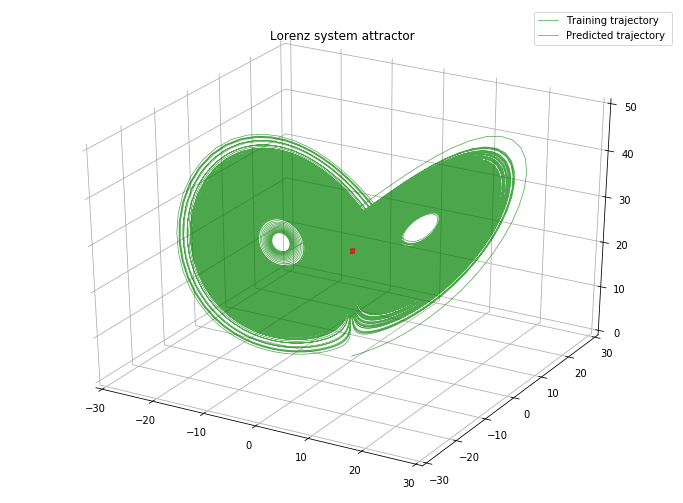

In [30]:
g= ND22D(x_pred,3)
print(g)
plot_lorenz(g,train.values[:g.shape[0]],1)